In [484]:
# !git clone git@github.com:cisagov/vulnrichment.git    

In [485]:
import os
import json
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


## Read JSON ADP SSVC Values into a df

In [486]:
root_directory = '../tmp/vulnrichment'

In [487]:

def extract_metrics_from_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        metrics = {}
        cve_id = os.path.splitext(os.path.basename(file_path))[0]  # Extract filename without extension as cveId
        metrics['cve'] = cve_id  # Store cveId in metrics dictionary
        containers = data.get('containers', {})
        for adp_data in containers.get('adp', []):
            metrics_data = adp_data.get('metrics', [])
            for metric in metrics_data:
                other = metric.get('other', {})
                content = other.get('content', {})
                if content.get('id') == cve_id:
                    for option in content.get('options', []):
                        if 'Exploitation' in option:
                            metrics['Exploitation'] = option['Exploitation']
                        if 'Automatable' in option:
                            metrics['Automatable'] = option['Automatable']
                        if 'Technical Impact' in option:
                            metrics['Technical Impact'] = option['Technical Impact']

        # Extract vectorString from 'cvssV3_1' section under 'adp'
        adp_section = containers.get('adp', [])
        if adp_section:
            for metric in adp_section[0].get('metrics', []):
                cvssV3_1 = metric.get('cvssV3_1', {})
                if cvssV3_1:
                    metrics['vectorString'] = cvssV3_1.get('vectorString', '')
        
        return metrics

def extract_metrics_from_directory(root_dir):
    all_metrics = []
    for root, _, files in os.walk(root_dir):
        for file_name in files:
            if file_name.endswith('.json'):
                file_path = os.path.join(root, file_name)
                metrics = extract_metrics_from_json(file_path)
                if metrics:
                    all_metrics.append(metrics)
    return all_metrics

metrics_list = extract_metrics_from_directory(root_directory)

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(metrics_list)

# Reorder columns to have 'cveId' as the first column
if 'cve' in df.columns:
    df = df[['cve', 'vectorString', 'Exploitation', 'Automatable', 'Technical Impact']]

# Display the DataFrame (you can manipulate it further as needed)
df


,cve,vectorString,Exploitation,Automatable,Technical Impact
0,CVE-2021-1675,NaN,active,no,total
1,CVE-2021-32039,NaN,none,no,partial
2,CVE-2021-42574,NaN,poc,no,total
3,CVE-2021-42295,NaN,none,no,partial
4,CVE-2021-35001,NaN,none,no,partial
...,...,...,...,...,...
10250,CVE-2024-37150,NaN,none,no,partial
10251,CVE-2024-37350,NaN,none,no,partial
10252,CVE-2024-37535,CVSS:3.1/AV:L/AC:L/PR:H/UI:N/S:U/C:N/I:N/A:H,poc,no,partial
10253,CVE-2024-37313,NaN,none,yes,partial


In [488]:
df.vectorString.value_counts().sum()

1168

## Check Values
The values are mixed case - so convert all to Title case

In [489]:
df.Exploitation.value_counts()

none      9055
poc       1016
None        57
active      55
Active      19
PoC         11
Name: Exploitation, dtype: int64

In [490]:
df.Automatable.value_counts()

no     8906
yes    1218
No       56
Yes      33
Name: Automatable, dtype: int64

In [491]:
df['Technical Impact'].value_counts()

partial    7201
total      2923
Total        85
Partial       4
Name: Technical Impact, dtype: int64

In [492]:
# Convert values in 'Exploitation', 'Automatable', 'Technical Impact' columns to title case
df['Exploitation'] = df['Exploitation'].apply(lambda x: x.title() if isinstance(x, str) else x)
df['Automatable'] = df['Automatable'].apply(lambda x: x.title() if isinstance(x, str) else x)
df['Technical Impact'] = df['Technical Impact'].apply(lambda x: x.title() if isinstance(x, str) else x)


In [493]:
df.Exploitation.value_counts()

None      9112
Poc       1027
Active      74
Name: Exploitation, dtype: int64

In [494]:
df.Automatable.value_counts()

No     8962
Yes    1251
Name: Automatable, dtype: int64

In [495]:
df['Technical Impact'].value_counts()

Partial    7205
Total      3008
Name: Technical Impact, dtype: int64

## Get CVSS Base Parameters

Several JSON files don't have CVSS base parameters or score e.g.
* vulnrichment/2024/22xxx/CVE-2024-22365.json 
* vulnrichment/2018/20xxx/CVE-2018-20735.json

````
find . -type f -name "*.json" -exec grep -H "baseScore" {} + | wc -l
9425
````

So use a different source for these.


In [496]:
URL="https://raw.githubusercontent.com/t0sche/cvss-bt/main/cvss-bt.csv"
df_cvss = pd.read_csv(URL)
df_cvss

/tmp/ipykernel_3197574/271777378.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cvss = pd.read_csv(URL)


,cve,cvss-bt_score,cvss-bt_severity,cvss-bt_vector,cvss_version,base_score,base_severity,base_vector,assigner,published_date,epss,cisa_kev,vulncheck_kev,exploitdb,metasploit,nuclei,poc_github
0,CVE-1999-0095,9.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C/E:POC,2.0,10.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1988-10-01T04:00Z,0.07764,False,False,True,False,False,False
1,CVE-1999-0082,8.5,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C/E:U,2.0,10.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1988-11-11T05:00Z,0.015,False,False,False,False,False,False
2,CVE-1999-1471,6.1,MEDIUM,AV:L/AC:L/Au:N/C:C/I:C/A:C/E:U,2.0,7.2,HIGH,AV:L/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1989-01-01T05:00Z,0.00043,False,False,False,False,False,False
3,CVE-1999-1122,3.9,LOW,AV:L/AC:L/Au:N/C:P/I:P/A:P/E:U,2.0,4.6,MEDIUM,AV:L/AC:L/Au:N/C:P/I:P/A:P,cve@mitre.org,1989-07-26T04:00Z,0.0006,False,False,False,False,False,False
4,CVE-1999-1467,8.5,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C/E:U,2.0,10.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1989-10-26T04:00Z,0.00299,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254275,CVE-2024-5574,6.9,MEDIUM,CVSS:3.1/AV:N/AC:H/PR:L/UI:N/S:U/C:H/I:H/A:H/E:U,3.1,7.5,HIGH,CVSS:3.1/AV:N/AC:H/PR:L/UI:N/S:U/C:H/I:H/A:H,cve-request@wordfence.com,2024-06-19T06:15Z,0.00056,False,False,False,False,False,False
254276,CVE-2024-5853,9.1,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:H/I:H/A:H/E:U,3.1,9.9,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:H/I:H/A:H,cve-request@wordfence.com,2024-06-19T06:15Z,0.0005,False,False,False,False,False,False
254277,CVE-2024-5343,5.9,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N/E:U,3.1,6.4,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,cve-request@wordfence.com,2024-06-19T06:15Z,0.00045,False,False,False,False,False,False
254278,CVE-2024-6132,8.1,HIGH,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H/E:U,3.1,8.8,HIGH,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,cve-request@wordfence.com,2024-06-19T06:15Z,0.0005,False,False,False,False,False,False


In [497]:
# Merge df and df_cvss on 'cveId', adding 'base_vector' column from df_cvss to df
df_merged = pd.merge(df, df_cvss[['cve', 'base_vector', 'cisa_kev', 'nuclei', 'metasploit', 'exploitdb', 'poc_github']], on='cve', how='left')
df_merged

,cve,vectorString,Exploitation,Automatable,Technical Impact,base_vector,cisa_kev,nuclei,metasploit,exploitdb,poc_github
0,CVE-2021-1675,NaN,Active,No,Total,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,True,False,True,False,True
1,CVE-2021-32039,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,False,False,False,False,False
2,CVE-2021-42574,NaN,Poc,No,Total,CVSS:3.1/AV:N/AC:H/PR:N/UI:R/S:C/C:H/I:H/A:H,False,False,False,False,True
3,CVE-2021-42295,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N,False,False,False,False,False
4,CVE-2021-35001,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
10250,CVE-2024-37150,NaN,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False
10251,CVE-2024-37350,NaN,None,No,Partial,NaN,NaN,NaN,NaN,NaN,NaN
10252,CVE-2024-37535,CVSS:3.1/AV:L/AC:L/PR:H/UI:N/S:U/C:N/I:N/A:H,Poc,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,False,False,False,False,False
10253,CVE-2024-37313,NaN,None,Yes,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False


In [498]:
df_valid = df_merged.dropna(subset=['vectorString', 'base_vector'])

# Compare vectorString with base_vector
df_valid['vectorString_matches_base'] = df_valid['vectorString'] == df_valid['base_vector']
df_valid

/tmp/ipykernel_3197574/2659700914.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['vectorString_matches_base'] = df_valid['vectorString'] == df_valid['base_vector']


,cve,vectorString,Exploitation,Automatable,Technical Impact,base_vector,cisa_kev,nuclei,metasploit,exploitdb,poc_github,vectorString_matches_base
7,CVE-2021-26928,CVSS:3.1/AV:N/AC:H/PR:L/UI:N/S:U/C:H/I:N/A:H,Poc,No,Partial,CVSS:3.1/AV:N/AC:H/PR:L/UI:N/S:U/C:H/I:N/A:H,False,False,False,False,False,True
9,CVE-2021-26918,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,Poc,Yes,Total,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,False,False,False,False,False,True
79,CVE-2021-47464,CVSS:3.1/AV:L/AC:H/PR:N/UI:N/S:U/C:H/I:H/A:H,None,No,Total,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,False,False,False,False,False,False
81,CVE-2021-47329,CVSS:3.1/AV:L/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,False,False,False,False,False,False
114,CVE-2021-47368,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:H,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
10244,CVE-2024-37643,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,Poc,No,Total,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,False,False,False,False,False,True
10246,CVE-2024-37569,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:L,Poc,No,Total,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,False,False,False,False,False,False
10248,CVE-2024-37634,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,Poc,Yes,Total,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,False,False,False,False,False,False
10252,CVE-2024-37535,CVSS:3.1/AV:L/AC:L/PR:H/UI:N/S:U/C:N/I:N/A:H,Poc,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,False,False,False,False,False,False


In [499]:
df_merged['base_vector'].isna().sum()

220

In [500]:
# Drop rows with NaN values in 'base_vector' column
df_merged.dropna(subset=['base_vector'], inplace=True)
df_merged

,cve,vectorString,Exploitation,Automatable,Technical Impact,base_vector,cisa_kev,nuclei,metasploit,exploitdb,poc_github
0,CVE-2021-1675,NaN,Active,No,Total,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,True,False,True,False,True
1,CVE-2021-32039,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,False,False,False,False,False
2,CVE-2021-42574,NaN,Poc,No,Total,CVSS:3.1/AV:N/AC:H/PR:N/UI:R/S:C/C:H/I:H/A:H,False,False,False,False,True
3,CVE-2021-42295,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N,False,False,False,False,False
4,CVE-2021-35001,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
10249,CVE-2024-37305,NaN,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False
10250,CVE-2024-37150,NaN,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False
10252,CVE-2024-37535,CVSS:3.1/AV:L/AC:L/PR:H/UI:N/S:U/C:N/I:N/A:H,Poc,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,False,False,False,False,False
10253,CVE-2024-37313,NaN,None,Yes,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False


In [501]:
df_merged

,cve,vectorString,Exploitation,Automatable,Technical Impact,base_vector,cisa_kev,nuclei,metasploit,exploitdb,poc_github
0,CVE-2021-1675,NaN,Active,No,Total,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,True,False,True,False,True
1,CVE-2021-32039,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,False,False,False,False,False
2,CVE-2021-42574,NaN,Poc,No,Total,CVSS:3.1/AV:N/AC:H/PR:N/UI:R/S:C/C:H/I:H/A:H,False,False,False,False,True
3,CVE-2021-42295,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N,False,False,False,False,False
4,CVE-2021-35001,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
10249,CVE-2024-37305,NaN,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False
10250,CVE-2024-37150,NaN,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False
10252,CVE-2024-37535,CVSS:3.1/AV:L/AC:L/PR:H/UI:N/S:U/C:N/I:N/A:H,Poc,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,False,False,False,False,False
10253,CVE-2024-37313,NaN,None,Yes,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False


In [502]:
def exploitation_dt(row):
    if row['cisa_kev']:
        return "Active"
    elif (row['exploitdb'] | row['poc_github'] | row['nuclei'] | row['metasploit']):
    #elif (row['exploitdb'] | row['poc_github'] ):
        return "Poc"
    else:
        return "None"

In [503]:
df_merged['_Exploitation'] = df_merged.apply(exploitation_dt, axis=1)
df_merged


,cve,vectorString,Exploitation,Automatable,Technical Impact,base_vector,cisa_kev,nuclei,metasploit,exploitdb,poc_github,_Exploitation
0,CVE-2021-1675,NaN,Active,No,Total,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,True,False,True,False,True,Active
1,CVE-2021-32039,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,False,False,False,False,False,None
2,CVE-2021-42574,NaN,Poc,No,Total,CVSS:3.1/AV:N/AC:H/PR:N/UI:R/S:C/C:H/I:H/A:H,False,False,False,False,True,Poc
3,CVE-2021-42295,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N,False,False,False,False,False,None
4,CVE-2021-35001,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,False,False,False,False,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...
10249,CVE-2024-37305,NaN,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None
10250,CVE-2024-37150,NaN,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None
10252,CVE-2024-37535,CVSS:3.1/AV:L/AC:L/PR:H/UI:N/S:U/C:N/I:N/A:H,Poc,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,False,False,False,False,False,None
10253,CVE-2024-37313,NaN,None,Yes,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None


In [504]:
# Function to convert CVSS vector string to dictionary
def cvss_vector_to_dict(cvss_vector):
    cvss_dict = {}
    elements = cvss_vector.split('/')
    for element in elements:
        key, value = element.split(':')
        cvss_dict[key] = value
    return cvss_dict

In [505]:
# Add cvss_vector_dict column
df_merged['cvss_vector_dict'] = df_merged['base_vector'].apply(cvss_vector_to_dict)
df_merged

,cve,vectorString,Exploitation,Automatable,Technical Impact,base_vector,cisa_kev,nuclei,metasploit,exploitdb,poc_github,_Exploitation,cvss_vector_dict
0,CVE-2021-1675,NaN,Active,No,Total,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,True,False,True,False,True,Active,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N..."
1,CVE-2021-32039,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'L..."
2,CVE-2021-42574,NaN,Poc,No,Total,CVSS:3.1/AV:N/AC:H/PR:N/UI:R/S:C/C:H/I:H/A:H,False,False,False,False,True,Poc,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'H', 'PR': 'N..."
3,CVE-2021-42295,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N..."
4,CVE-2021-35001,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10249,CVE-2024-37305,NaN,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L..."
10250,CVE-2024-37150,NaN,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'N..."
10252,CVE-2024-37535,CVSS:3.1/AV:L/AC:L/PR:H/UI:N/S:U/C:N/I:N/A:H,Poc,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L..."
10253,CVE-2024-37313,NaN,None,Yes,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L..."


# Calculate SSVC Decision Node Outputs

In [506]:
#V3 base score parameters
#https://www.first.org/cvss/v3-1/ or https://www.first.org/cvss/v3-0
#'availabilityImpact/'confidentialityImpact', 'integrityImpact'}
#Low (L)
#High (H)
#None (N)

#https://www.first.org/cvss/v2/guide
#Confidentiality/Integrity/Availability:
#None (N)
#Partial (P)
#Complete (C)

# Function to determine impact
def technical_impact_dt(cvss_dict):
    if (('CVSS' in cvss_dict and ((cvss_dict['CVSS'] == '3.1' ) | (cvss_dict['CVSS'] == '3.0')) and  (cvss_dict['C'] == 'H') and (cvss_dict['I'] == 'H')))  or (('C' in cvss_dict and cvss_dict['C'] == 'C') and ('I' in cvss_dict and cvss_dict['I'] == 'C')):
        return "Total"
    else:
        return "Partial"


In [507]:
df_merged['_Technical Impact'] = df_merged['cvss_vector_dict'].apply(technical_impact_dt)
df_merged

,cve,vectorString,Exploitation,Automatable,Technical Impact,base_vector,cisa_kev,nuclei,metasploit,exploitdb,poc_github,_Exploitation,cvss_vector_dict,_Technical Impact
0,CVE-2021-1675,NaN,Active,No,Total,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,True,False,True,False,True,Active,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...",Total
1,CVE-2021-32039,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'L...",Partial
2,CVE-2021-42574,NaN,Poc,No,Total,CVSS:3.1/AV:N/AC:H/PR:N/UI:R/S:C/C:H/I:H/A:H,False,False,False,False,True,Poc,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'H', 'PR': 'N...",Total
3,CVE-2021-42295,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...",Partial
4,CVE-2021-35001,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...",Total
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10249,CVE-2024-37305,NaN,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L...",Partial
10250,CVE-2024-37150,NaN,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'N...",Partial
10252,CVE-2024-37535,CVSS:3.1/AV:L/AC:L/PR:H/UI:N/S:U/C:N/I:N/A:H,Poc,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L...",Total
10253,CVE-2024-37313,NaN,None,Yes,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L...",Partial


In [508]:
def automatable_dt(cvss_dict):
 
    # ((userInteraction == 'NONE') & (attackComplexity == 'LOW') & (privilegesRequired != 'HIGH') & (attackVector == 'NETWORK')):
    if (('CVSS' in cvss_dict and ((cvss_dict['CVSS'] == '3.1') | (cvss_dict['CVSS'] == '3.0')) and  cvss_dict['UI'] == 'N' and cvss_dict['AC'] == 'L' and cvss_dict['PR'] != 'H' and cvss_dict['AV'] == 'N') or \
    (cvss_dict['AC'] == 'L' and cvss_dict['AV'] == 'N' and ('Au' in cvss_dict and cvss_dict['Au'] == 'N'))):

        return "Yes"
    else:
        return "No"

In [509]:
def automatable_dt(cvss_dict):
 
    # ((userInteraction == 'NONE') & (attackComplexity == 'LOW') & (privilegesRequired != 'HIGH') & (attackVector == 'NETWORK')):
    if (('CVSS' in cvss_dict and ((cvss_dict['CVSS'] == '3.1') | (cvss_dict['CVSS'] == '3.0')) and  cvss_dict['UI'] == 'N' and cvss_dict['AC'] == 'L' and cvss_dict['PR'] != 'H' ) or \
    (cvss_dict['AC'] == 'L' and cvss_dict['AV'] == 'N' and ('Au' in cvss_dict and cvss_dict['Au'] == 'N'))):

        return "Yes"
    else:
        return "No"

In [510]:
def automatable_dt(cvss_dict):
 
    # ((userInteraction == 'NONE') & (attackComplexity == 'LOW') & (privilegesRequired != 'HIGH') & (attackVector == 'NETWORK')):
    if (('CVSS' in cvss_dict and ((cvss_dict['CVSS'] == '3.1') | (cvss_dict['CVSS'] == '3.0')) and  cvss_dict['UI'] == 'N'  and cvss_dict['PR'] != 'H' ) or \
    (cvss_dict['AC'] == 'L' and cvss_dict['AV'] == 'N' and ('Au' in cvss_dict and cvss_dict['Au'] == 'N'))):

        return "Yes"
    else:
        return "No"

In [511]:
df_merged['_Automatable_cvssbase'] = df_merged['cvss_vector_dict'].apply(automatable_dt)
df_merged

,cve,vectorString,Exploitation,Automatable,Technical Impact,base_vector,cisa_kev,nuclei,metasploit,exploitdb,poc_github,_Exploitation,cvss_vector_dict,_Technical Impact,_Automatable_cvssbase
0,CVE-2021-1675,NaN,Active,No,Total,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,True,False,True,False,True,Active,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...",Total,No
1,CVE-2021-32039,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'L...",Partial,Yes
2,CVE-2021-42574,NaN,Poc,No,Total,CVSS:3.1/AV:N/AC:H/PR:N/UI:R/S:C/C:H/I:H/A:H,False,False,False,False,True,Poc,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'H', 'PR': 'N...",Total,No
3,CVE-2021-42295,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...",Partial,No
4,CVE-2021-35001,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...",Total,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10249,CVE-2024-37305,NaN,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L...",Partial,Yes
10250,CVE-2024-37150,NaN,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'N...",Partial,Yes
10252,CVE-2024-37535,CVSS:3.1/AV:L/AC:L/PR:H/UI:N/S:U/C:N/I:N/A:H,Poc,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L...",Total,Yes
10253,CVE-2024-37313,NaN,None,Yes,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L...",Partial,Yes


In [512]:
df_merged['_Automatable'] = (
    (df_merged['_Automatable_cvssbase'] == 'Yes') |
    (df_merged['metasploit']) |
    (df_merged['nuclei'])
)

# Convert boolean values to 'Yes' and 'No'
df_merged['_Automatable'] = df_merged['_Automatable'].map({True: 'Yes', False: 'No'})


In [513]:
df_merged['_Automatable'] = df_merged['_Automatable_cvssbase']

In [514]:
df_merged.dropna(subset=['Exploitation', '_Exploitation'], inplace=True)
df_merged

,cve,vectorString,Exploitation,Automatable,Technical Impact,base_vector,cisa_kev,nuclei,metasploit,exploitdb,poc_github,_Exploitation,cvss_vector_dict,_Technical Impact,_Automatable_cvssbase,_Automatable
0,CVE-2021-1675,NaN,Active,No,Total,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,True,False,True,False,True,Active,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...",Total,No,No
1,CVE-2021-32039,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'L...",Partial,Yes,Yes
2,CVE-2021-42574,NaN,Poc,No,Total,CVSS:3.1/AV:N/AC:H/PR:N/UI:R/S:C/C:H/I:H/A:H,False,False,False,False,True,Poc,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'H', 'PR': 'N...",Total,No,No
3,CVE-2021-42295,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...",Partial,No,No
4,CVE-2021-35001,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...",Total,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10249,CVE-2024-37305,NaN,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L...",Partial,Yes,Yes
10250,CVE-2024-37150,NaN,None,No,Partial,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'N...",Partial,Yes,Yes
10252,CVE-2024-37535,CVSS:3.1/AV:L/AC:L/PR:H/UI:N/S:U/C:N/I:N/A:H,Poc,No,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L...",Total,Yes,Yes
10253,CVE-2024-37313,NaN,None,Yes,Partial,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:C/C:L/I:L/A:N,False,False,False,False,False,None,"{'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'L...",Partial,Yes,Yes


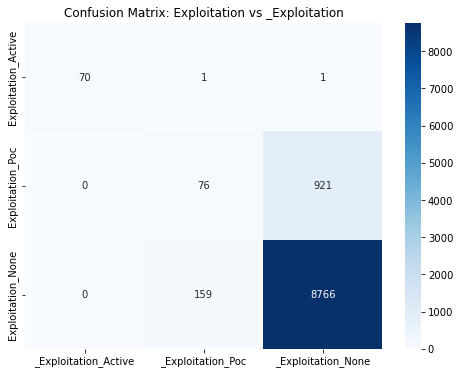

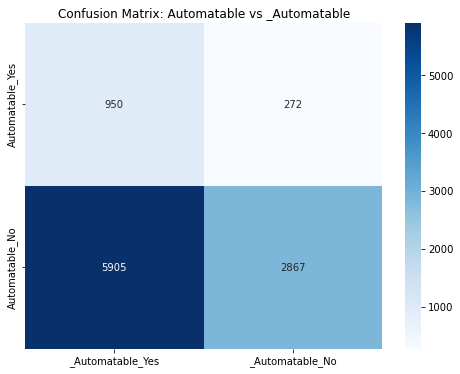

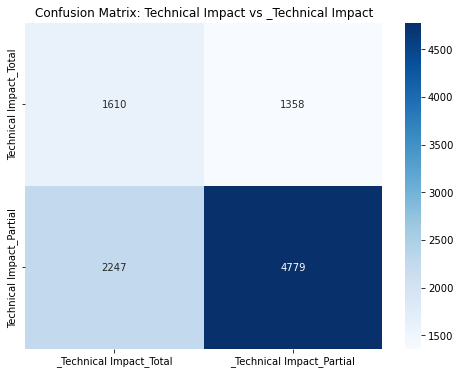

In [515]:

# Define a function to plot confusion matrix
def plot_confusion_matrix(df, col1, col2, labels, title):
    conf_matrix = confusion_matrix(df[col1], df[col2], labels=labels)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=[f'{col1}_{label}' for label in labels],
                                  columns=[f'{col2}_{label}' for label in labels])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.show()

# Plotting confusion matrices for the specified columns
plot_confusion_matrix(df_merged, 'Exploitation', '_Exploitation', ['Active', 'Poc', 'None'], 'Confusion Matrix: Exploitation vs _Exploitation')
plot_confusion_matrix(df_merged, 'Automatable', '_Automatable', ['Yes', 'No'], 'Confusion Matrix: Automatable vs _Automatable')
plot_confusion_matrix(df_merged, 'Technical Impact', '_Technical Impact', ['Total', 'Partial'], 'Confusion Matrix: Technical Impact vs _Technical Impact')

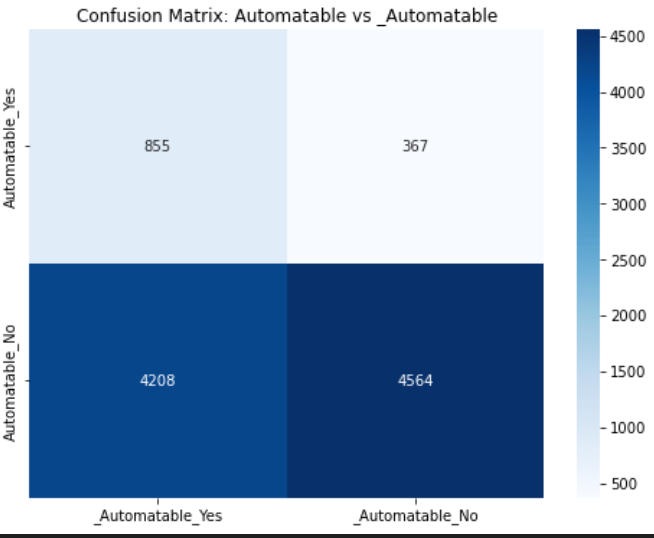

# Correlation of Parameters

In [516]:
print(df_merged.cvss_vector_dict.head(10))

0    {'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...
1    {'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'L...
2    {'CVSS': '3.1', 'AV': 'N', 'AC': 'H', 'PR': 'N...
3    {'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...
4    {'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...
5    {'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...
6    {'CVSS': '3.1', 'AV': 'L', 'AC': 'L', 'PR': 'N...
7    {'CVSS': '3.1', 'AV': 'N', 'AC': 'H', 'PR': 'L...
8    {'CVSS': '3.1', 'AV': 'L', 'AC': 'H', 'PR': 'L...
9    {'CVSS': '3.1', 'AV': 'N', 'AC': 'L', 'PR': 'N...
Name: cvss_vector_dict, dtype: object


In [517]:
# Define a function to parse the CVSS vector
def parse_cvss_vector(vector):
    elements = vector.split('/')
    version = None
    metrics = {}
    
    # Check if the first element is the version
    if elements[0].startswith('CVSS'):
        version = elements[0]
        elements = elements[1:]
    
    for element in elements:
        key, value = element.split(':')
        metrics[key] = value
    
    return version, metrics

# Parse the base_vector and create separate columns
df_merged['version'] = df_merged['base_vector'].apply(lambda x: parse_cvss_vector(x)[0])
df_merged['metrics'] = df_merged['base_vector'].apply(lambda x: parse_cvss_vector(x)[1])

# Normalize the metrics dictionary to separate columns
metrics_df = pd.json_normalize(df_merged['metrics'])

# Combine the original DataFrame with the metrics DataFrame
df_merged = pd.concat([df_merged, metrics_df], axis=1).drop(columns=['metrics'])
df_merged

,cve,vectorString,Exploitation,Automatable,Technical Impact,base_vector,cisa_kev,nuclei,metasploit,exploitdb,...,version,AV,AC,PR,UI,S,C,I,A,Au
0,CVE-2021-1675,NaN,Active,No,Total,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,True,False,True,False,...,CVSS:3.1,L,L,N,R,U,H,H,H,NaN
1,CVE-2021-32039,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,False,False,False,False,...,CVSS:3.1,L,L,L,N,U,H,N,N,NaN
2,CVE-2021-42574,NaN,Poc,No,Total,CVSS:3.1/AV:N/AC:H/PR:N/UI:R/S:C/C:H/I:H/A:H,False,False,False,False,...,CVSS:3.1,N,H,N,R,C,H,H,H,NaN
3,CVE-2021-42295,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N,False,False,False,False,...,CVSS:3.1,L,L,N,R,U,H,N,N,NaN
4,CVE-2021-35001,NaN,None,No,Partial,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,False,False,False,False,...,CVSS:3.1,L,L,N,R,U,H,H,H,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,N,L,L,R,C,L,L,N,NaN
9951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,N,L,N,N,C,L,L,N,NaN
9958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,N,L,H,R,C,L,L,N,NaN
9988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,N,L,L,N,U,H,H,H,NaN


### CVSS Versions
* 9919 of CVEs are CVSS 3.1.
* 262  of CVEs are CVSS 2 or earlier i.e. earlier that CVSS 3.0
* 61  of CVEs are CVSS 3.0

In [518]:
df_merged.version.value_counts()

CVSS:3.1    9919
CVSS:3.0      61
Name: version, dtype: int64

In [519]:
df_merged.version.isna().value_counts()

False    9980
True      262
Name: version, dtype: int64

### Correlation of Parameters

1. Exploitation is highly correlated with CISA KEV (0.71 but not 1); this suggests not all CVEs in CISA KEV 

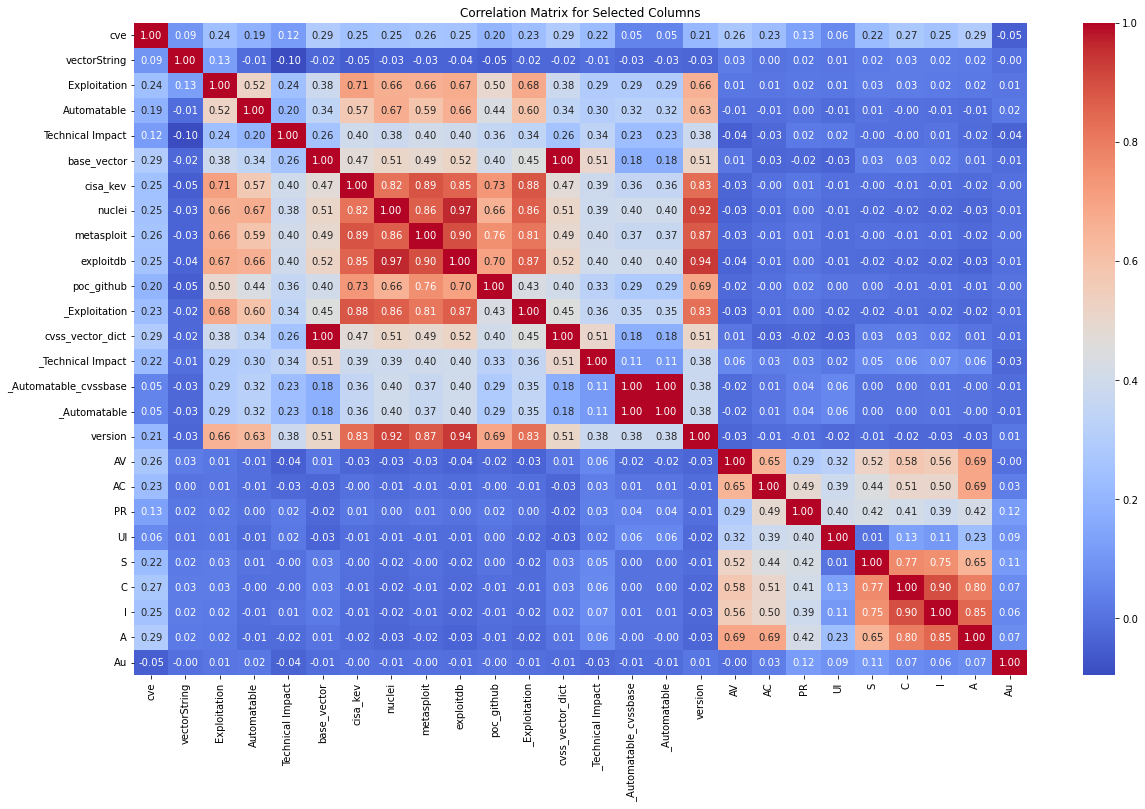

In [520]:
df_merged = df_merged.astype(str)

# Convert categorical variables to numerical codes
df_encoded = df_merged.apply(lambda x: pd.factorize(x)[0])

# Calculate the correlation matrix
correlation_matrix = df_encoded.corr()

# Plot the correlation matrix
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Selected Columns')
plt.show()

# See which parameters contribute most to Exploitation, Automatable, Technical Impact

In [521]:
df

,cve,vectorString,Exploitation,Automatable,Technical Impact
0,CVE-2021-1675,NaN,Active,No,Total
1,CVE-2021-32039,NaN,None,No,Partial
2,CVE-2021-42574,NaN,Poc,No,Total
3,CVE-2021-42295,NaN,None,No,Partial
4,CVE-2021-35001,NaN,None,No,Partial
...,...,...,...,...,...
10250,CVE-2024-37150,NaN,None,No,Partial
10251,CVE-2024-37350,NaN,None,No,Partial
10252,CVE-2024-37535,CVSS:3.1/AV:L/AC:L/PR:H/UI:N/S:U/C:N/I:N/A:H,Poc,No,Partial
10253,CVE-2024-37313,NaN,None,Yes,Partial


In [522]:
df=df_merged.copy()
df.drop(columns=['cve', 'cvss_vector_dict', 'base_vector', 'vectorString', '_Technical Impact', '_Automatable', '_Exploitation', 'version'], inplace=True)

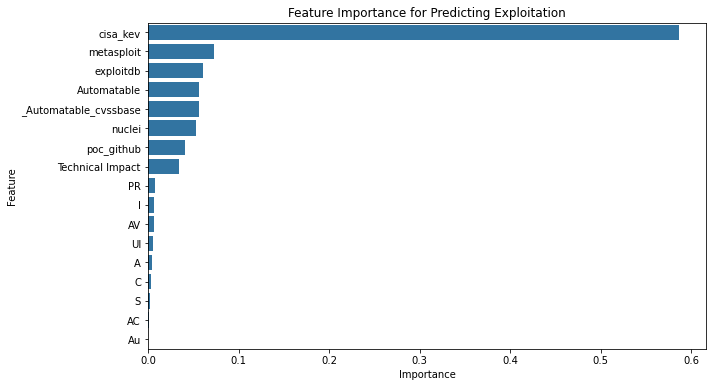

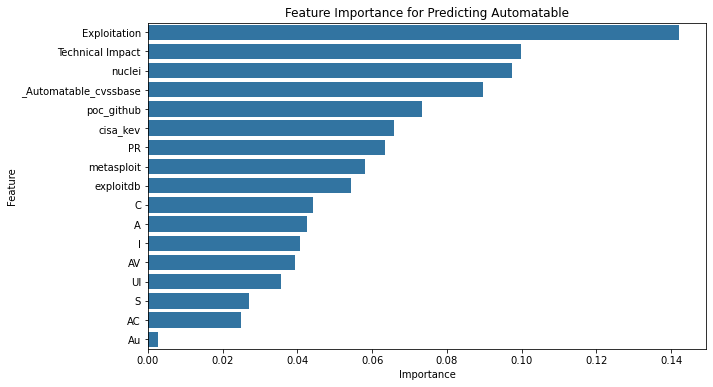

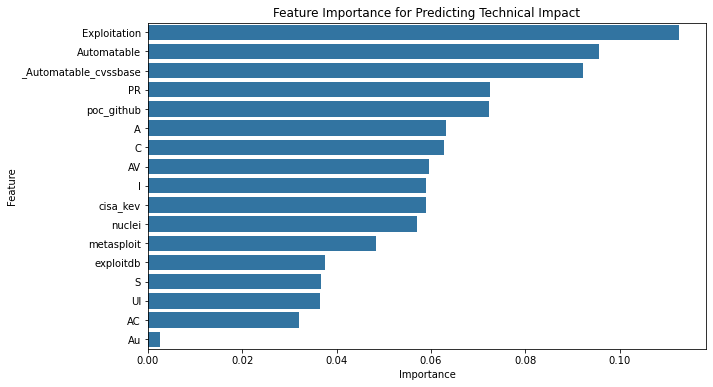

In [523]:
# Encode categorical variables
label_encoders = {}
for column in df.columns:
    if df[column].dtype == 'object':
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le

# Define a function to train a model and plot feature importance
def plot_feature_importance(df, target_column, target_value=None):
    if target_value is not None:
        target_label = label_encoders[target_column].transform([target_value])[0]
        df[target_column] = (df[target_column] == target_label).astype(int)

    X = df.drop([target_column], axis=1)
    y = df[target_column]

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)

    feature_importances = clf.feature_importances_

    features = X.columns
    importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importances_df = importances_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importances_df)
    plt.title(f'Feature Importance for Predicting {target_column}')
    plt.show()

# Plot feature importance for each target column
plot_feature_importance(df.copy(), 'Exploitation', 'Active')
plot_feature_importance(df.copy(), 'Automatable')
plot_feature_importance(df.copy(), 'Technical Impact')